In [1]:
import pandas as pd
import re
import numpy as np
import joblib
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import math
from sklearn import model_selection, svm
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVR, LinearSVC, SVC
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, cross_val_predict
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from itertools import product
from sklearn.model_selection import StratifiedKFold
from matplotlib.cm import get_cmap
from sklearn.metrics import precision_recall_fscore_support
from collections import Counter
from scipy.sparse import csr_matrix
from sklearn.metrics import accuracy_score
import itertools

In [11]:
df = pd.read_excel('labelling.xlsx')
df.head(10)

,text,Username,tweet_tokens_stemmed,label
0,huhu thank you so much for sharing smangat kit...,Orbitingtoyeom,"['huhu', 'thank', 'you', 'so', 'much', 'for', ...",POSITIVE
1,hope he would take it easy if he starts drawi...,rietveldkz,"['hope', 'he', 'would', 'take', 'it', 'easy', ...",NEGATIVE
2,hahaha aku lemah dalam mempertahankan hubungan...,mhmdbrq,"['hahaha', 'lemah', 'tahan', 'hubung', 'pentin...",NEGATIVE
3,mereka lupa yg sedang dilawan itu gt populasi ...,sastrawanto,"['lupa', 'lawan', 'gt', 'populasi', 'manusia',...",NEGATIVE
4,ya mungkin emg bnyk yg seolah dibuatbuat tapi ...,kadalkejepit,"['emg', 'bnyk', 'dibuatbuat', 'butuh', 'progra...",POSITIVE
5,kewarasan otak dan kesehatan mental aku masih ...,nantikelarkok,"['waras', 'otak', 'sehat', 'mental', 'utama', ...",NEGATIVE
6,jaga kesehatan mental dan fisik masing masing ...,jenoyayak,"['jaga', 'sehat', 'mental', 'fisik', 'ngelakui...",POSITIVE
7,bulan pertama berjuang sana sini sendirian akh...,SiskaTeukie,"['juang', 'nyerah', 'karna', 'bener', 'makan',...",NEGATIVE
8,kesehatan mental diatas segalanya segera nyari...,cndrasptian,"['sehat', 'mental', 'atas', 'nyari', 'kerja', ...",NEGATIVE
9,gangguan mental tapi sadar sih belakangan ini ...,ryanotanto,"['ganggu', 'mental', 'sadar', 'dunia', 'sosmed...",NEGATIVE


Label: NEGATIVE, Count: 5546
Label: POSITIVE, Count: 4193


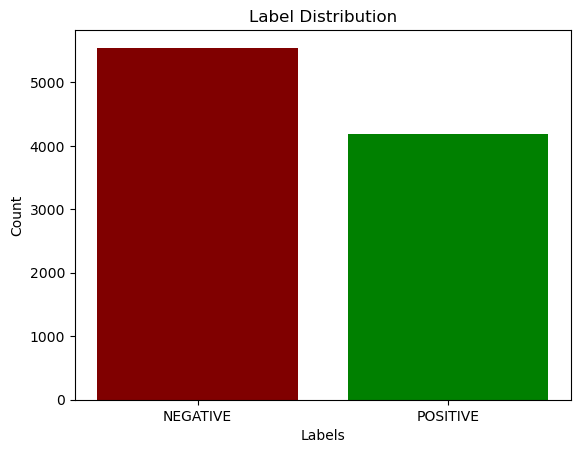

In [4]:
# Assuming your label column is named 'label', you can count the occurrences of each label
label_counts = df['label'].value_counts()

# Extract the labels and their counts
labels = label_counts.index
counts = label_counts.values

# Define colors for positive and negative labels
colors = ['maroon', 'green']

# Create a bar chart with different colors for each label
plt.bar(labels, counts, color=colors)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Distribution')

# Print the length of each label category
for label, count in zip(labels, counts):
    print(f'Label: {label}, Count: {count}')

plt.show()

In [5]:
def convert(polarity):
    if polarity == 'Positive':
        return 1
    elif polarity == 'Negative':
        return -1

In [6]:
df['Polarity'] = df['label'].apply(convert)

In [7]:
x = df['tweet_tokens_stemmed']
y = df['Polarity']

In [8]:
# Your documents or text data
documents = [
    "This is the first document.",
    "This is the second document.",
    # ... add more documents ...
]

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the TF-IDF vectorizer on the documents
x_train_tfidf = tfidf_vectorizer.fit_transform(x)

# Access the vocabulary (terms) from the TfidfVectorizer
terms = tfidf_vectorizer.get_feature_names_out()

# Get the TF-IDF matrix as an array
tfidf_matrix_array = x_train_tfidf.toarray()

# Convert the TF-IDF array to a DataFrame with terms as columns
tfidf_df = pd.DataFrame(data=tfidf_matrix_array, columns=terms)

# Total terms in each document
total_terms_per_document = tfidf_df.sum(axis=1)

# Count TF and DF for each term
tf_counts = tfidf_df.div(total_terms_per_document, axis=0)  # TF: count of term divided by total terms in document
df_counts = (tfidf_df > 0).sum()  # DF: count non-zero values to get DF

# Create a new DataFrame to display TF, DF, IDF, and TF-IDF
tf_df_counts = pd.DataFrame({'Term': terms, 'TF': tf_counts.sum(), 'DF': df_counts})

# Calculate the log base 10 for IDF using the DataFrame
tf_df_counts['IDF'] = tf_df_counts['DF'].apply(lambda df: math.log10(len(x) / df))

# Calculate the TF-IDF for each term in each document
for term in terms:
    tf_df_counts['TF-IDF'] = tf_df_counts['TF'] * tf_df_counts['IDF']

# Print the resulting DataFrame with TF, DF, IDF, and TF-IDF values
print(tf_df_counts)

                    Term        TF  DF       IDF    TF-IDF
aa                    aa  0.231153   1  3.988514  0.921955
aaaa                aaaa  0.061527   1  3.988514  0.245400
aaaaaaaa        aaaaaaaa  0.056865   1  3.988514  0.226807
aaaaaaaaaaa  aaaaaaaaaaa  0.063393   1  3.988514  0.252845
aaaagggg        aaaagggg  0.065448   1  3.988514  0.261042
...                  ...       ...  ..       ...       ...
zoom                zoom  0.683537  10  2.988514  2.042760
zoy                  zoy  0.063859   1  3.988514  0.254702
zuper              zuper  0.075601   1  3.988514  0.301535
zuzur              zuzur  0.066903   1  3.988514  0.266843
zweitheart    zweitheart  0.454906   1  3.988514  1.814398

[14323 rows x 5 columns]


In [35]:
import math
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Your documents or text data
documents = [
    "This is the first document with ganjar.",
    "This is the second document without ganjar.",
    # ... add more documents ...
]

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the TF-IDF vectorizer on the documents
x_train_tfidf = tfidf_vectorizer.fit_transform(x)

# Access the vocabulary (terms) from the TfidfVectorizer
terms = tfidf_vectorizer.get_feature_names_out()

# Get the TF-IDF matrix as an array
tfidf_matrix_array = x_train_tfidf.toarray()

# Convert the TF-IDF array to a DataFrame with terms as columns
tfidf_df = pd.DataFrame(data=tfidf_matrix_array, columns=terms)

# Count DF for each term
df_counts = (tfidf_df > 0).sum()  # DF: count non-zero values to get DF

# Create a new DataFrame to display TF, DF, IDF, and TF-IDF
tf_df_counts = pd.DataFrame({'Term': terms, 'DF': df_counts})

# Filter terms with DF greater than 1
filtered_terms = tf_df_counts.loc[tf_df_counts['DF'] > 1, 'Term']

# Calculate the log base 10 for IDF using the DataFrame
tf_df_counts['IDF'] = tf_df_counts['DF'].apply(lambda df: math.log10(len(x) / df))

# Create a DataFrame to store TF, DF, IDF, and TF-IDF values for each document
document_values = pd.DataFrame({'Document': range(1, len(x) + 1)})

# Calculate TF, IDF, and TF-IDF for each document for filtered terms
for term in filtered_terms:
    term_index = np.where(terms == term)[0][0]

    # Calculate TF for each document
    tf_values = (tfidf_df.iloc[:, term_index] / tfidf_df.sum(axis=1)).to_numpy()

    # Calculate TF-IDF for each document
    tf_idf_values = tf_values * tf_df_counts.loc[tf_df_counts['Term'] == term, 'IDF'].values[0]

    # Add columns to the document_values DataFrame
    document_values[f'{term}_TF'] = tf_values
    document_values[f'{term}_DF'] = tf_df_counts.loc[tf_df_counts['Term'] == term, 'DF'].values[0]
    document_values[f'{term}_IDF'] = tf_df_counts.loc[tf_df_counts['Term'] == term, 'IDF'].values[0]
    document_values[f'{term}_TF-IDF'] = tf_idf_values

# Print the resulting DataFrame with TF, DF, IDF, and TF-IDF values for each document
print(document_values)


   Document  chotimah_TF  chotimah_DF  chotimah_IDF  chotimah_TF-IDF  \
0         1     0.000000            2      0.477121         0.000000   
1         2     0.000000            2      0.477121         0.000000   
2         3     0.000000            2      0.477121         0.000000   
3         4     0.000000            2      0.477121         0.000000   
4         5     0.217151            2      0.477121         0.103607   
5         6     0.110570            2      0.477121         0.052755   

     doa_TF  doa_DF   doa_IDF  doa_TF-IDF  ganjar_TF  ...  pranowo_IDF  \
0  0.040886       2  0.477121    0.019507   0.022133  ...     0.477121   
1  0.000000       2  0.477121    0.000000   0.047004  ...     0.477121   
2  0.000000       2  0.477121    0.000000   0.044585  ...     0.477121   
3  0.052578       2  0.477121    0.025086   0.028462  ...     0.477121   
4  0.000000       2  0.477121    0.000000   0.117551  ...     0.477121   
5  0.000000       2  0.477121    0.000000   0.05985

In [38]:
import math
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Your documents or text data
documents = [
    "This is the first document with ganjar.",
    "This is the second document without ganjar.",
    # ... add more documents ...
]

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the TF-IDF vectorizer on the documents
x_train_tfidf = tfidf_vectorizer.fit_transform(x)

# Access the vocabulary (terms) from the TfidfVectorizer
terms = np.array(tfidf_vectorizer.get_feature_names_out())

# Get the TF-IDF matrix as an array
tfidf_matrix_array = x_train_tfidf.toarray()

# Convert the TF-IDF array to a DataFrame with terms as columns
tfidf_df = pd.DataFrame(data=tfidf_matrix_array, columns=terms)

# Count DF for each term
df_counts = (tfidf_df > 0).sum()  # DF: count non-zero values to get DF

# Create a new DataFrame to display TF, DF, IDF, and TF-IDF
tf_df_counts = pd.DataFrame({'Term': terms, 'DF': df_counts})

# Filter terms with DF greater than 1
filtered_terms = tf_df_counts.loc[tf_df_counts['DF'] > 1, 'Term']

# Create a DataFrame to store TF, DF, IDF, and TF-IDF values for each document
document_values = pd.DataFrame({'Document': range(1, len(x) + 1)})

# Loop through each term with DF > 1
for term in filtered_terms:
    term_index = np.where(terms == term)[0][0]

    # Calculate TF for each document
    tf_values = (tfidf_df.iloc[:, term_index] / tfidf_df.sum(axis=1)).to_numpy()

    # Calculate IDF for the term
    idf_value = math.log10(len(x) / df_counts[term])

    # Calculate TF-IDF for each document
    tf_idf_values = tf_values * idf_value

    # Add columns to the document_values DataFrame
    document_values[f'{term}_TF'] = tf_values
    document_values[f'{term}_DF'] = df_counts[term]
    document_values[f'{term}_IDF'] = idf_value
    document_values[f'{term}_TF-IDF'] = tf_idf_values

# Print the resulting DataFrame with TF, DF, IDF, and TF-IDF values for each document
print(document_values)

   Document  chotimah_TF  chotimah_DF  chotimah_IDF  chotimah_TF-IDF  \
0         1     0.000000            2      0.477121         0.000000   
1         2     0.000000            2      0.477121         0.000000   
2         3     0.000000            2      0.477121         0.000000   
3         4     0.000000            2      0.477121         0.000000   
4         5     0.217151            2      0.477121         0.103607   
5         6     0.110570            2      0.477121         0.052755   

     doa_TF  doa_DF   doa_IDF  doa_TF-IDF  ganjar_TF  ...  pranowo_IDF  \
0  0.040886       2  0.477121    0.019507   0.022133  ...     0.477121   
1  0.000000       2  0.477121    0.000000   0.047004  ...     0.477121   
2  0.000000       2  0.477121    0.000000   0.044585  ...     0.477121   
3  0.052578       2  0.477121    0.025086   0.028462  ...     0.477121   
4  0.000000       2  0.477121    0.000000   0.117551  ...     0.477121   
5  0.000000       2  0.477121    0.000000   0.05985

In [9]:
x_train_tfidf

<5000x10516 sparse matrix of type '<class 'numpy.float64'>'
	with 68900 stored elements in Compressed Sparse Row format>

In [10]:
x_train_tfidf.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [11]:
print(x_train_tfidf)

  (0, 3335)	0.3500835799628773
  (0, 4354)	0.26439874095405663
  (0, 3536)	0.16862771128297407
  (0, 8867)	0.3126505685462289
  (0, 7445)	0.22474205137674105
  (0, 7538)	0.19462631411235587
  (0, 5583)	0.21836000137672015
  (0, 1962)	0.4922190140263922
  (0, 5283)	0.26116737564538867
  (0, 967)	0.03808493461628485
  (0, 10004)	0.03815355910186099
  (0, 8519)	0.12487538496939933
  (0, 7110)	0.3741540702161322
  (0, 6221)	0.27622524427758127
  (1, 5691)	0.24775301538162164
  (1, 9494)	0.23676938891220647
  (1, 6232)	0.29492398863403735
  (1, 3458)	0.20633273611481157
  (1, 8425)	0.18823514425750026
  (1, 3598)	0.21146622337993817
  (1, 7649)	0.18034358960929528
  (1, 7722)	0.40412991562740075
  (1, 9078)	0.21330238107838898
  (1, 7633)	0.22671786085921916
  (1, 7952)	0.4184282207371844
  :	:
  (4997, 1558)	0.23567307142463043
  (4997, 4916)	0.20673653036267267
  (4997, 778)	0.21446571132877967
  (4997, 5209)	0.18933087340468305
  (4997, 373)	0.22284035537416838
  (4997, 6365)	0.195451042

Fold 1 - Train indices: 4500
Fold 1 - Test indices: 500
Fold 1 - Train indices: [   0    1    2 ... 4997 4998 4999]
Fold 1 - Test indices: [   5   18   50   60   62   72   74   79   82   92   97  114  117  123
  136  138  160  196  199  221  222  223  229  231  235  265  280  282
  288  298  301  305  310  311  317  320  326  330  332  343  345  347
  351  354  372  384  392  405  408  413  418  434  442  443  445  465
  466  483  486  490  500  502  506  512  514  517  519  524  530  534
  545  560  565  567  587  608  609  612  619  632  646  647  649  665
  668  670  680  684  696  708  709  710  744  749  752  766  770  824
  835  849  853  877  888  889  892  895  906  913  940  945  963  977
 1012 1017 1021 1035 1036 1055 1062 1081 1089 1103 1111 1119 1124 1138
 1141 1160 1163 1165 1175 1182 1185 1196 1213 1217 1227 1239 1240 1249
 1272 1273 1279 1284 1286 1290 1304 1311 1325 1332 1335 1340 1352 1382
 1434 1438 1442 1457 1467 1476 1479 1495 1499 1501 1506 1521 1522 1530
 1540 154

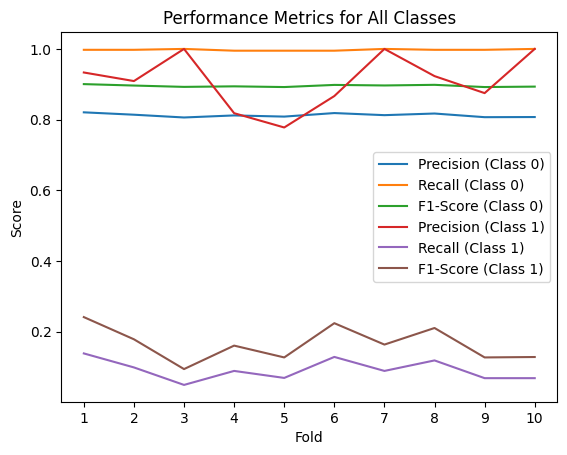

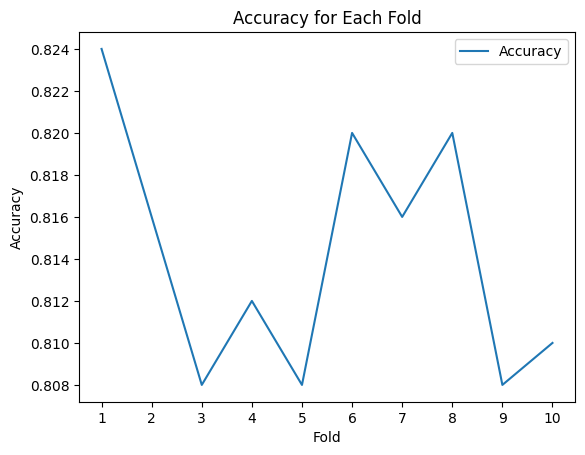

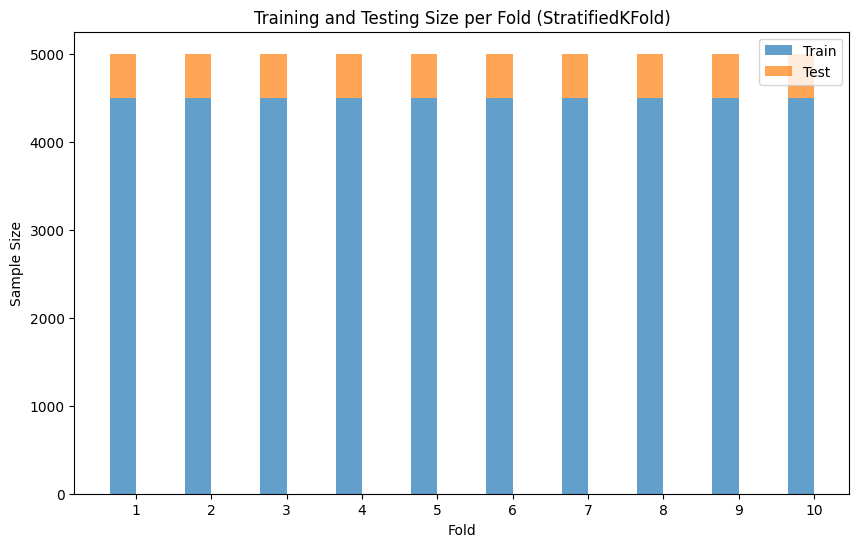

Fold 1:
Classification Report:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90       399
           1       0.93      0.14      0.24       101

    accuracy                           0.82       500
   macro avg       0.88      0.57      0.57       500
weighted avg       0.84      0.82      0.77       500



Fold 2:
Classification Report:
              precision    recall  f1-score   support

           0       0.81      1.00      0.90       399
           1       0.91      0.10      0.18       101

    accuracy                           0.82       500
   macro avg       0.86      0.55      0.54       500
weighted avg       0.83      0.82      0.75       500



Fold 3:
Classification Report:
              precision    recall  f1-score   support

           0       0.81      1.00      0.89       399
           1       1.00      0.05      0.09       101

    accuracy                           0.81       500
   macro avg       0.90      0.

In [12]:
# Set a fixed random seed for reproducibility
random_seed = 42
np.random.seed(random_seed)

# Create a Multinomial Naive Bayes classifier
nb = MultinomialNB()

# Define the number of cross-validation folds
num_folds = 10

fold_numbers = list(range(1, 11))  # Create a list of fold numbers

# Set a fixed random state for StratifiedKFold
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=random_seed)

# Initialize a list to store the number of training and testing samples per fold
train_sizes = []
test_sizes = []

# Initialize a list to store the combined training and testing sizes per fold
fold_sizes = []

# Initialize a matrix to represent both training and testing data
matrix = np.zeros((num_folds, x_train_tfidf.shape[0]))

# Initialize lists to store metrics for each fold
classification_reports = []
accuracies_scores_nb = []
precision_scores_nb = []
recall_scores_nb = []
f1_scores_nb = []

# Initialize lists to store metrics for each fold
nb_accuracies = []

best_accuracy_nb = 0.0
best_f1_score_nb = 0.0
best_fold_index = -1

# Initialize lists to store precision, recall, and F1-score for each class
precision_scores_by_class = [[] for _ in range(2)]
recall_scores_by_class = [[] for _ in range(2)]
f1_scores_by_class = [[] for _ in range(2)]

# Initialize a list to store accuracy
accuracies = []

# Create a color map for lines
cmap = plt.get_cmap('tab10')

# Perform cross-validation and find the fold with the highest accuracy
for fold, (train_index, test_index) in enumerate(kf.split(x_train_tfidf, y)):
    X_train_fold, X_test_fold = x_train_tfidf[train_index], x_train_tfidf[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    
    #Menampilkan Train dan Testing dari StratifiedKFold
    train_count = len(train_index)
    test_count = len(test_index)
    print(f"Fold {fold + 1} - Train indices: {train_count}")
    print(f"Fold {fold + 1} - Test indices: {test_count}")
          
    print(f"Fold {fold + 1} - Train indices: {train_index}")
    print(f"Fold {fold + 1} - Test indices: {test_index}")
    
    # Create a Multinomial Naive Bayes classifier
    nb = MultinomialNB()
    
    # Train the model on the training fold
    nb.fit(X_train_fold, y_train_fold)
    
    # Make predictions on the test fold
    preds = nb.predict(X_test_fold)
    
    # Calculate the accuracy for the fold
    accuracy = accuracy_score(y_test_fold, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test_fold, preds, average='weighted')
    
    # Check if the current fold has a higher accuracy or F1-score
    if accuracy > best_accuracy_nb and f1 > best_f1_score_nb:
        best_accuracy_nb = accuracy
        best_f1_score_nb = f1
        best_fold_index = fold
        best_classification_report_nb = classification_report(y_test_fold, preds, output_dict=True)
    
    accuracies_scores_nb.append(accuracy)
    precision_scores_nb.append(precision)
    recall_scores_nb.append(recall)
    f1_scores_nb.append(f1)
    
    # Generate and store a classification report for the fold
    class_report = classification_report(y_test_fold, preds)
    classification_reports.append(class_report)
    
    train_size = len(train_index)
    test_size = len(test_index)
    train_sizes.append(train_size)
    test_sizes.append(test_size)
    
   # Generate classification report
    class_report = classification_report(y_test_fold, preds, output_dict=True)

    # Calculate precision, recall, and F1-score for each class
    for cls in range(2):
        precision = class_report[str(cls)]['precision']
        recall = class_report[str(cls)]['recall']
        f1 = class_report[str(cls)]['f1-score']

        precision_scores_by_class[cls].append(precision)
        recall_scores_by_class[cls].append(recall)
        f1_scores_by_class[cls].append(f1)

    # Calculate and store accuracy
    accuracy = accuracy_score(y_test_fold, preds)
    accuracies.append(accuracy)

# Create a line chart for precision, recall, F1-score, and accuracy for both classes
# Create a list of fold numbers from 1 to 10
fold_numbs = list(range(1, num_folds + 1))
# plt.figure(figsize=(10, 6))
for cls in range(2):
    plt.plot(fold_numbs, precision_scores_by_class[cls], label=f'Precision (Class {cls})')
    plt.plot(fold_numbs, recall_scores_by_class[cls], label=f'Recall (Class {cls})')
    plt.plot(fold_numbs, f1_scores_by_class[cls], label=f'F1-Score (Class {cls})')

# Add labels and title
plt.xlabel('Fold')
plt.ylabel('Score')
plt.title('Performance Metrics for All Classes')

# Show the legend
plt.legend()

# Set x-axis ticks to display all fold numbers from 1 to 10
plt.xticks(fold_numbers)

# Save the chart as an image file (e.g., PNG)
plt.savefig('evaluation_metrics_chart_both_classes.png')

# Show the chart
plt.show()

plt.plot(fold_numbers, accuracies, label='Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Accuracy for Each Fold')
plt.legend()
plt.xticks(fold_numbers)
plt.savefig('accuracy_chart_nb.png')
plt.show()

# Create an array for fold numbers
folds = np.arange(1, num_folds + 1)

# Width of the bars
bar_width = 0.35

# Create a bar chart to visualize training and testing sizes for each fold
plt.figure(figsize=(10, 6))
plt.bar(folds, train_sizes, bar_width, label='Train', alpha=0.7)
plt.bar(folds, test_sizes, bar_width, bottom=train_sizes, label='Test', alpha=0.7)

# Add labels and title
plt.xlabel('Fold')
plt.ylabel('Sample Size')
plt.title('Training and Testing Size per Fold (StratifiedKFold)')

# Show legend
plt.legend()

# Set x-axis labels for all the folds
plt.xticks(folds + bar_width / 2, folds)

# Save the bar chart as an image file (e.g., PNG)
plt.savefig('training_testing_sizes_per_fold.png')

# Show the bar chart
plt.show()

# Find the fold with the highest accuracy
best_fold = np.argmax(accuracies_scores_nb)
best_accuracy_nb = accuracies_scores_nb[best_fold]
best_classification_report_nb = classification_reports[best_fold]

# Convert the generator to a list to access elements
kf_splits = list(kf.split(x_train_tfidf, y))

# Get the train and test data for the best fold
train_index, test_index = list(kf.split(x_train_tfidf, y))[best_fold]
X_train_best_fold, X_test_best_fold = x_train_tfidf[train_index], x_train_tfidf[test_index]
y_train_best_fold, y_test_best_fold = y.iloc[train_index], y.iloc[test_index]

# Train the model on the best fold
nb.fit(X_train_best_fold, y_train_best_fold)

# Make predictions on the test data of the best fold
preds_best_fold = nb.predict(X_test_best_fold)

# Generate and store a classification report for the best fold


# Calculate the confusion matrix for the best fold
confusion_matrix_best_fold = confusion_matrix(y_test_best_fold, preds_best_fold)
nb_accuracies.append(confusion_matrix_best_fold)

# Print or analyze the results for each fold
for i in range(num_folds):
    print(f"Fold {i + 1}:")
    print("Classification Report:")
    print(classification_reports[i])
    print("\n")

# Print the results for the best fold, including the confusion matrix
# print(f"Best Fold (Fold {best_fold + 1}):")
# print("Classification Report:")
# print(best_classification_report_nb)
# print(f"Best Accuracy: {best_accuracy_nb:.2f}")
# print("Confusion Matrix:")
# print(confusion_matrix_best_fold)

# Print the best fold index, accuracy, F1-score, and the classification report
print(f"The best fold with the highest accuracy and F1-score is Fold {best_fold_index + 1}")
print(f"Best Accuracy: {best_accuracy_nb:.2f}")
print(f"Best F1-Score: {best_f1_score_nb:.2f}")
print("Classification Report for the Best Fold:")
print(best_classification_report_nb)

In [13]:
print(y_test_best_fold)
print(preds_best_fold)

5       0
18      0
50      0
60      0
62      1
       ..
4935    0
4951    0
4956    1
4970    0
4980    0
Name: Polarity, Length: 500, dtype: int64
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 

In [14]:
Final = df[['text', 'tweet_tokens_stemmed', 'label', 'Polarity']]

In [15]:
result_matrics = (confusion_matrix(y_test_best_fold, preds_best_fold))
print(result_matrics)

[[398   1]
 [ 87  14]]


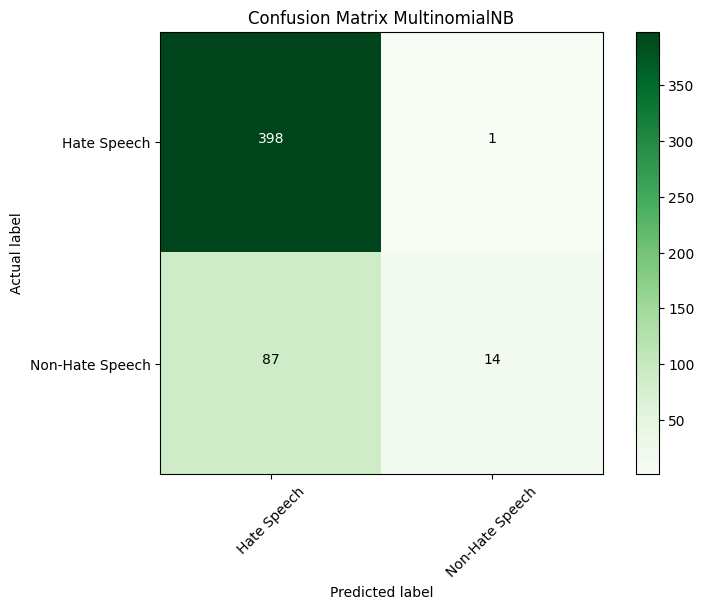

In [16]:
def plot_confusion_matrix(cm, target_names, title='Confusion Matrix MultinomialNB', cmap=None, normalize=False):
    """
    arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions
    """
     
    if cmap is None:
        cmap = plt.get_cmap('Greens')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylim(len(target_names)-0.5, -0.5)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.savefig(title + '.png', dpi=500, bbox_inches = 'tight')
    plt.show()
    
target_names = ('Hate Speech', 'Non-Hate Speech')
plot_confusion_matrix(result_matrics, target_names)

Classification report for C = 0.1:
Fold 1:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       399
           1       1.00      0.03      0.06       101

    accuracy                           0.80       500
   macro avg       0.90      0.51      0.47       500
weighted avg       0.84      0.80      0.72       500

Fold 2:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       399
           1       0.50      0.01      0.02       101

    accuracy                           0.80       500
   macro avg       0.65      0.50      0.45       500
weighted avg       0.74      0.80      0.71       500

Fold 3:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       399
           1       1.00      0.01      0.02       101

    accuracy                           0.80       500
   macro avg       0.90      0.50      0.45       500
weighted avg   

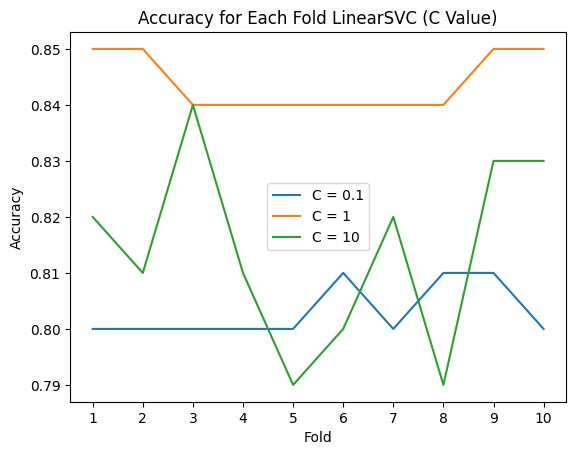

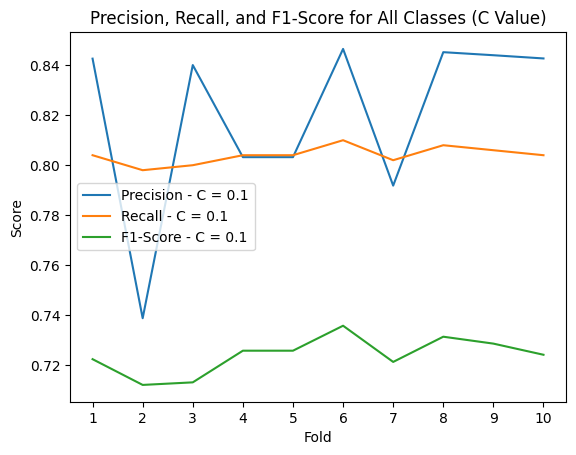

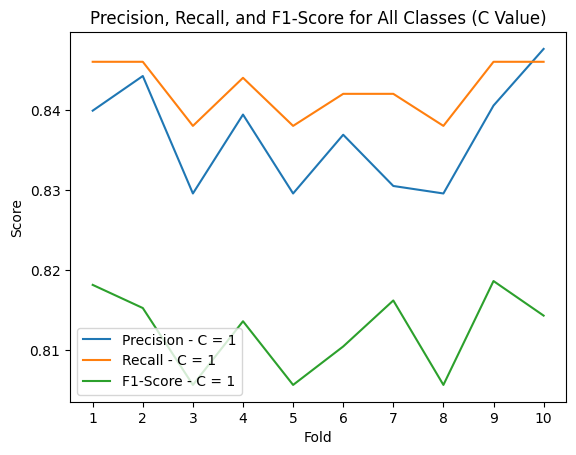

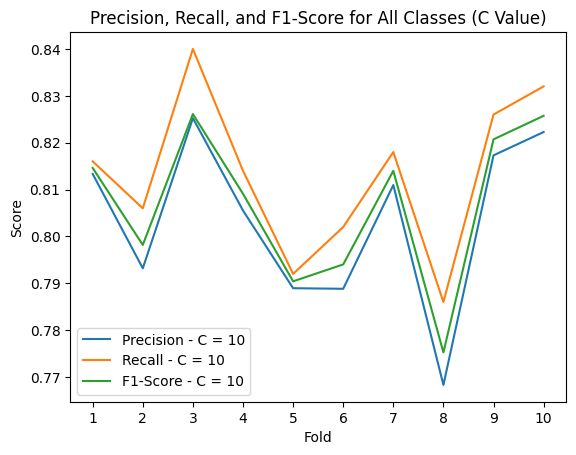

In [17]:
# Create the SVM classifier
svm = SVC()

# Define the parameter grid to search
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear']}

# Define the number of cross-validation folds
num_folds = 10

# Set a fixed random seed for reproducibility
random_seed = 42
np.random.seed(random_seed)

# Create StratifiedKFold for cross-validation
stratified_cv = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=random_seed)

# Create GridSearchCV with StratifiedKFold as the cross-validation strategy
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=stratified_cv)

# Fit the GridSearchCV to your data
grid_search.fit(x_train_tfidf, y)

# Access the cross-validation results
cv_results = grid_search.cv_results_

# Initialize variables to track the best accuracy and C value
best_accuracy_svm = 0.0
best_f1_score_svm = 0.0
best_C_value = 0
best_classification_report_svm = ""
best_train_indices = None  # Store the train indices for the best fold
best_test_indices = None  # Store the test indices for the best fold
best_fold_index = -1

# Initialize lists to store the accuracy for each fold
accuracies_svm = [[] for _ in param_grid['C']]
precision_by_param = [[] for _ in param_grid['C']]
recall_by_param = [[] for _ in param_grid['C']]
f1_score_by_param = [[] for _ in param_grid['C']]

# Initialize lists to store metrics for each fold
svm_accuracies = []

# Show classification report for each C value and fold
for param_index, param in enumerate(param_grid['C']):
    print(f"Classification report for C = {param}:")    
    for fold, (train_indices, test_indices) in enumerate(stratified_cv.split(x_train_tfidf, y)):
        best_model = grid_search.best_estimator_
        best_model.set_params(C=param)
        x_train_fold, x_test_fold = x_train_tfidf[train_indices], x_train_tfidf[test_indices]
        y_train_fold, y_test_fold = y.iloc[train_indices], y.iloc[test_indices]
        best_model.fit(x_train_fold, y_train_fold)
        y_pred = best_model.predict(x_test_fold)
        report = classification_report(y_test_fold, y_pred, zero_division=1)
        precision, recall, f1, _ = precision_recall_fscore_support(y_test_fold, y_pred, average='weighted')
        print(f"Fold {fold + 1}:")
        print(report)

        # Calculate and track the accuracy
        report_lines = report.split('\n')
        accuracy_svm = float(report_lines[5].split()[1])  # Extract accuracy from the report
        f1_score_svm = f1_score(y_test_fold, y_pred, average='weighted')
        accuracies_svm[param_index].append(accuracy_svm)
        precision_by_param[param_index].append(precision)
        recall_by_param[param_index].append(recall)
        f1_score_by_param[param_index].append(f1_score_svm)
        
        if accuracy_svm > best_accuracy_svm or (accuracy_svm == best_accuracy_svm and f1_score_svm > best_f1_score_svm):
            best_accuracy_svm = accuracy_svm
            best_f1_score_svm = f1_score_svm
            best_C_value = param
            best_classification_report_svm = report
            best_train_indices = train_indices
            best_test_indices = test_indices
            best_fold_index = fold

# Calculate the confusion matrix for the best model
best_model.set_params(C=best_C_value)  # Set the best C value
best_model.fit(x_train_tfidf[best_train_indices], y.iloc[best_train_indices])  # Train the best model on the best train indices
y_pred_best = best_model.predict(x_train_tfidf[best_test_indices])  # Make predictions on the best test indices
confusion_matrix_best = confusion_matrix(y.iloc[best_test_indices], y_pred_best)  # Calculate the confusion matrix
svm_accuracies.append(confusion_matrix_best)

# Print the best fold index, the classification report for the highest accuracy and F1-score
print(f"The best fold is in Fold {best_fold_index + 1}")

# Print the classification report for the highest accuracy and F1-score
print("Classification report for the best fold:")
print(best_classification_report_svm)

# Print the confusion matrix for the best model
print("Confusion Matrix for the Best Model:")
print(confusion_matrix_best)

# Create a list of fold numbers from 1 to 10
fold_numbers = list(range(1, num_folds + 1))

# Create a line chart to visualize fold accuracies for different C values
for param_index, param in enumerate(param_grid['C']):
    plt.plot(fold_numbers, accuracies_svm[param_index], label=f'C = {param}')

# Set labels and title for the chart
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Accuracy for Each Fold LinearSVC (C Value)')

# Add a legend to the chart
plt.legend()

# Set the x-axis ticks to display all fold numbers
plt.xticks(fold_numbers)

# Save the line chart to a file (e.g., as a PNG image)
plt.savefig('accuracy_chart_svm.png')

# Show the line chart
plt.show()

# Create line charts for precision, recall, and F1-score for all classes
for param_index, param in enumerate(param_grid['C']):
    plt.plot(fold_numbers, precision_by_param[param_index], label=f'Precision - C = {param}')
    plt.plot(fold_numbers, recall_by_param[param_index], label=f'Recall - C = {param}')
    plt.plot(fold_numbers, f1_score_by_param[param_index], label=f'F1-Score - C = {param}')
    plt.xlabel('Fold')
    plt.ylabel('Score')
    plt.title(f'Precision, Recall, and F1-Score for All Classes (C Value)')
    plt.legend()
    plt.xticks(fold_numbers)
    plt.savefig(f'score_combined_svm_{param}.png')
    plt.show()

In [18]:
# Print the highest accuracy and the corresponding C value
print(f"Highest Accuracy: {best_accuracy_svm:.2f} for C = {best_C_value}")

# create the confusion matrix
cm = confusion_matrix(y.iloc[best_test_indices], y_pred_best)

# print the confusion matrix
print("Confusion matrix:")
print(cm)

# Print the classification report for the highest accuracy
print("Classification report for the highest accuracy:")
print(best_classification_report_svm)

Highest Accuracy: 0.85 for C = 1
Confusion matrix:
[[390   8]
 [ 69  33]]
Classification report for the highest accuracy:
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       398
           1       0.80      0.32      0.46       102

    accuracy                           0.85       500
   macro avg       0.83      0.65      0.69       500
weighted avg       0.84      0.85      0.82       500



In [19]:
# Split the classification report into lines
report_lines = best_classification_report_svm.split('\n')

# Extract accuracy from the report (usually the line at index 5)
accuracy_svm = float(report_lines[5].split()[1])

print(f"Accuracy Score of Best Classification Report: {accuracy_svm:.2f}")

Accuracy Score of Best Classification Report: 0.85


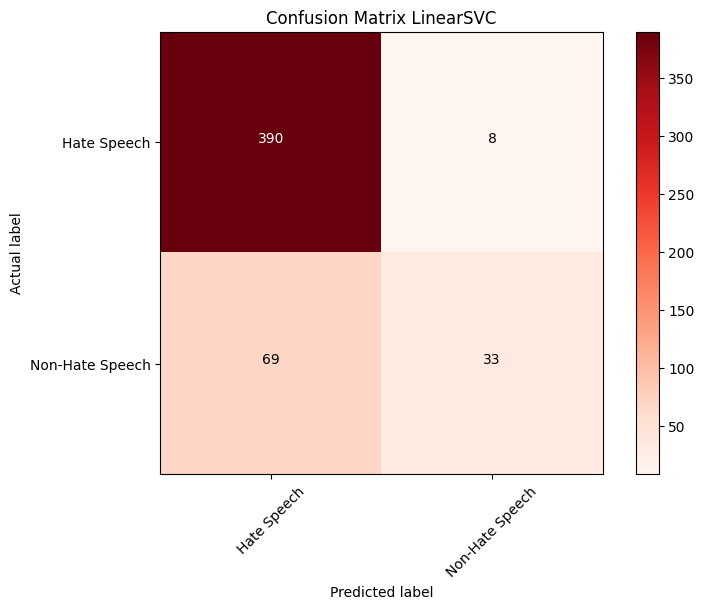

In [20]:
def plot_confusion_matrix(cm, target_names, title='Confusion Matrix LinearSVC', cmap=plt.cm.Reds, normalize=False):
    """
    arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions
    """
     
    if cmap is None:
        cmap = plt.get_cmap('Oranges')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylim(len(target_names)-0.5, -0.5)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.savefig(title + '.png', dpi=500, bbox_inches = 'tight')
    # plt.savefig(title + '.png')
    plt.show()
    
target_names = ('Hate Speech', 'Non-Hate Speech')
plot_confusion_matrix(cm, target_names)

In [21]:
# Assuming you have the classification report string stored in 'best_classification_report_nb'
report_nb = classification_report(y_test_best_fold, preds_best_fold, output_dict=True)

# Extract metrics for Class 0
class_0_metrics_nb = report_nb['0']
precision_class_0_nb = class_0_metrics_nb['precision']
recall_class_0_nb = class_0_metrics_nb['recall']
f1_score_class_0_nb = class_0_metrics_nb['f1-score']

# Extract metrics for Class 1
class_1_metrics_nb = report_nb['1']
precision_class_1_nb = class_1_metrics_nb['precision']
recall_class_1_nb = class_1_metrics_nb['recall']
f1_score_class_1_nb = class_1_metrics_nb['f1-score']

accuracy_nb = best_accuracy_nb

print("Metrics for Class 0:")
print(f'Precision: {precision_class_0_nb:.2f}')
print(f'Recall: {recall_class_0_nb:.2f}')
print(f'F1-Score: {f1_score_class_0_nb:.2f}')

print("Metrics for Class 1:")
print(f'Precision: {precision_class_1_nb:.2f}')
print(f'Recall: {recall_class_1_nb:.2f}')
print(f'F1-Score: {f1_score_class_1_nb:.2f}')

print(f'Accuracy: {accuracy_nb:.2f}')

Metrics for Class 0:
Precision: 0.82
Recall: 1.00
F1-Score: 0.90
Metrics for Class 1:
Precision: 0.93
Recall: 0.14
F1-Score: 0.24
Accuracy: 0.82


In [22]:
# Assuming you have the classification report string stored in 'best_classification_report_svm'
report_svm = classification_report(y.iloc[best_test_indices], y_pred_best, output_dict=True)

# Extract metrics for Class 0
class_0_metrics_svm = report_svm['0']
precision_class_0_svm = class_0_metrics_svm['precision']
recall_class_0_svm = class_0_metrics_svm['recall']
f1_score_class_0_svm = class_0_metrics_svm['f1-score']

# Extract metrics for Class 1
class_1_metrics_svm = report_svm['1']
precision_class_1_svm = class_1_metrics_svm['precision']
recall_class_1_svm = class_1_metrics_svm['recall']
f1_score_class_1_svm = class_1_metrics_svm['f1-score']

accuracy_svm = accuracy_svm

print("Metrics for Class 0:")
print(f'Precision: {precision_class_0_svm:.2f}')
print(f'Recall: {recall_class_0_svm:.2f}')
print(f'F1-Score: {f1_score_class_0_svm:.2f}')

print("Metrics for Class 1:")
print(f'Precision: {precision_class_1_svm:.2f}')
print(f'Recall: {recall_class_1_svm:.2f}')
print(f'F1-Score: {f1_score_class_1_svm:.2f}')

print(f'Accuracy: {accuracy_svm:.2f}')

Metrics for Class 0:
Precision: 0.85
Recall: 0.98
F1-Score: 0.91
Metrics for Class 1:
Precision: 0.80
Recall: 0.32
F1-Score: 0.46
Accuracy: 0.85


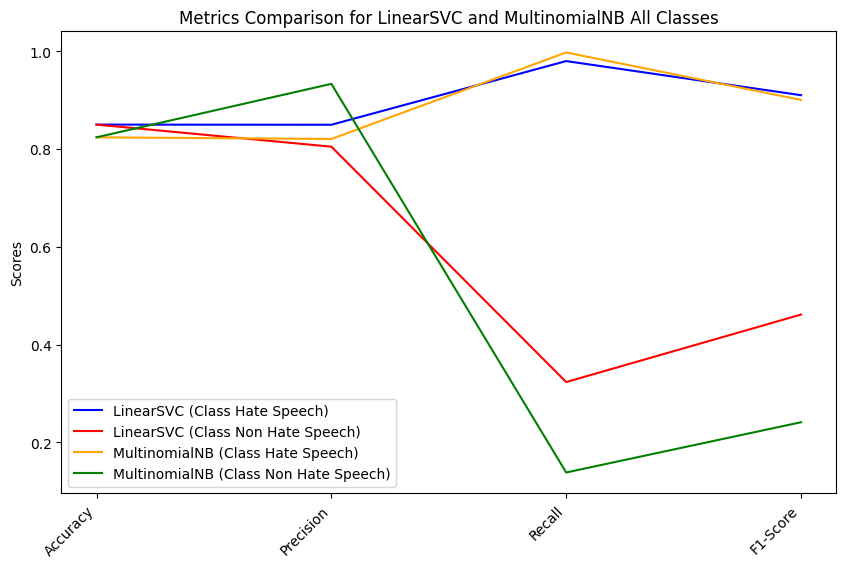

In [23]:
# Metrics and labels
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

# Define metrics for Class 0 and Class 1 for SVM Linear
svm_metrics_class0 = [accuracy_svm, precision_class_0_svm, recall_class_0_svm, f1_score_class_0_svm]
svm_metrics_class1 = [accuracy_svm, precision_class_1_svm, recall_class_1_svm, f1_score_class_1_svm]

# Define metrics for Class 0 and Class 1 for MultinomialNB
nb_metrics_class0 = [accuracy_nb, precision_class_0_nb, recall_class_0_nb, f1_score_class_0_nb]
nb_metrics_class1 = [accuracy_nb, precision_class_1_nb, recall_class_1_nb, f1_score_class_1_nb]

x = range(len(metrics))

plt.figure(figsize=(10, 6))

# Plot SVM Linear metrics for Class 0
plt.plot(x, svm_metrics_class0, label='LinearSVC (Class Hate Speech)', color='blue')

# Plot SVM Linear metrics for Class 1
plt.plot(x, svm_metrics_class1, label='LinearSVC (Class Non Hate Speech)', color='red')

# Plot MultinomialNB metrics for Class 0
plt.plot(x, nb_metrics_class0, label='MultinomialNB (Class Hate Speech)', color='orange')

# Plot MultinomialNB metrics for Class 1
plt.plot(x, nb_metrics_class1, label='MultinomialNB (Class Non Hate Speech)', color='green')

# plt.xticks(x, metrics)
plt.xticks(x, metrics)
plt.xticks(rotation=45, ha="right")  # Rotate and expand the tick labels
plt.ylabel('Scores')
plt.title('Metrics Comparison for LinearSVC and MultinomialNB All Classes')
plt.legend()
plt.grid(False)  # Set grid to False to remove it

# Save the plot to a file (in PNG format)
plt.savefig('metrics_comparison_nb_and_svm.png', bbox_inches='tight')

plt.show()

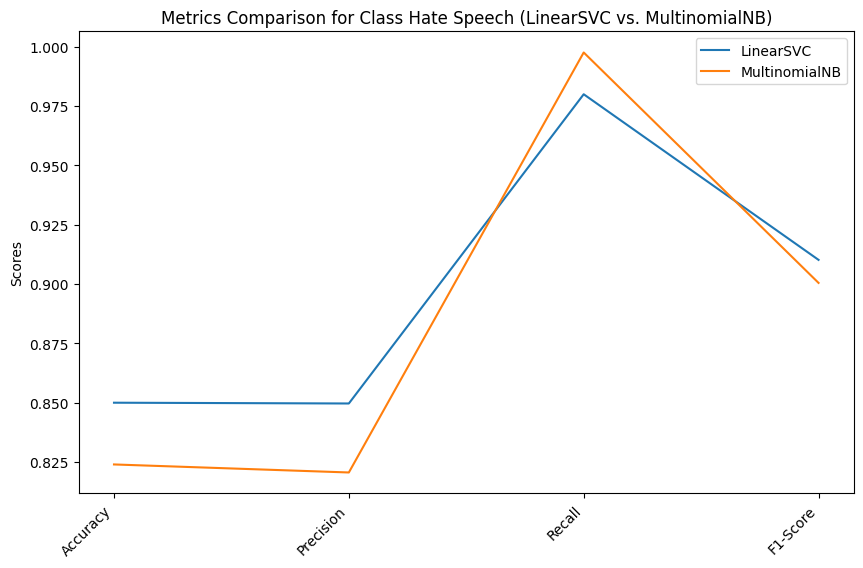

In [24]:
# Metrics and labels
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
svm_metrics = [accuracy_svm, precision_class_0_svm, recall_class_0_svm, f1_score_class_0_svm]
nb_metrics = [accuracy_nb, precision_class_0_nb, recall_class_0_nb, f1_score_class_0_nb]

x = range(len(metrics))

plt.figure(figsize=(10, 6))

# Plot SVM Linear metrics
plt.plot(x, svm_metrics, label='LinearSVC')

# Plot MultinomialNB metrics
# plt.plot(x, nb_metrics, label='MultinomialNB', linestyle='--', marker='o')
plt.plot(x, nb_metrics, label='MultinomialNB')

# plt.xticks(x, metrics)
plt.xticks(x, metrics, rotation=45, ha="right")  # Rotate the tick labels for readability
plt.ylabel('Scores')
plt.title('Metrics Comparison for Class Hate Speech (LinearSVC vs. MultinomialNB)')
plt.legend()

# Save the plot to a file (in PNG format)
plt.savefig('metrics_comparison_hs_nb_svm.png', bbox_inches='tight')

plt.show()

In [25]:
# Print the results for the best fold, including the confusion matrix
print(f"Best Fold (Fold {best_fold + 1}):")
print("Classification Report Naive Bayes:")
print(best_classification_report_nb)
print(f"Best Accuracy: {best_accuracy_nb:.2f}")

# Print the highest accuracy and the corresponding C value
print(f"Highest Accuracy Support Vector Machine: {best_accuracy_svm:.2f} for C = {best_C_value}")

# Print the classification report for the highest accuracy
print("Classification report for the highest accuracy Support Vector Machine:")
print(best_classification_report_svm)

Best Fold (Fold 1):
Classification Report Naive Bayes:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90       399
           1       0.93      0.14      0.24       101

    accuracy                           0.82       500
   macro avg       0.88      0.57      0.57       500
weighted avg       0.84      0.82      0.77       500

Best Accuracy: 0.82
Highest Accuracy Support Vector Machine: 0.85 for C = 1
Classification report for the highest accuracy Support Vector Machine:
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       398
           1       0.80      0.32      0.46       102

    accuracy                           0.85       500
   macro avg       0.83      0.65      0.69       500
weighted avg       0.84      0.85      0.82       500

